[saved] fig_data_scatter.png
[saved] fig_loss_lr.png
[saved] fig_boundary_train_lr0.001.png
[saved] fig_boundary_train_lr0.01.png
[saved] fig_boundary_train_lr0.1.png

Итоговые метрики (база):
LR        |  Train Acc |  Test Acc |  Final MSE
-----------------------------------------------
0.001     |      0.631 |     0.633 |     0.9475
0.01      |      0.638 |     0.628 |     0.9041
0.1       |      0.638 |     0.628 |     0.9041
[saved] fig_loss_modification.png
[saved] fig_boundary_train_momentum.png

Модификация (momentum+decay):
Train Acc | Test Acc | Final MSE
-------------------------------
    0.638 |    0.628 |    0.9041

[PDF] Собран общий отчёт с рисунками: report_delta_rule_moons.pdf

Краткие выводы:
- На линейно неразделимых «лунах» Adaline сходится по MSE к решению наименьших квадратов.
- Увеличение lr ускоряет начало спуска, но при слишком большом lr возможны колебания.
- Momentum+decay достигает плато быстрее и стабильнее базового варианта с фиксированным lr.
- Максимальн

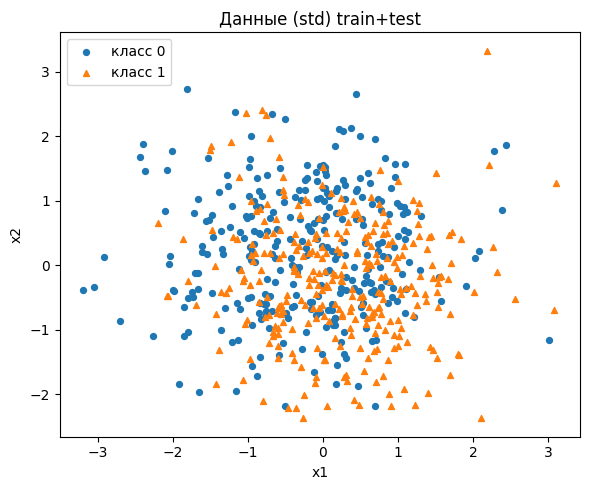

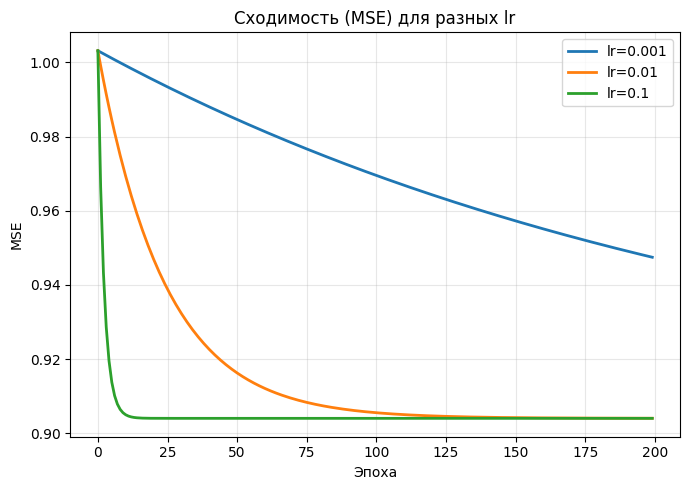

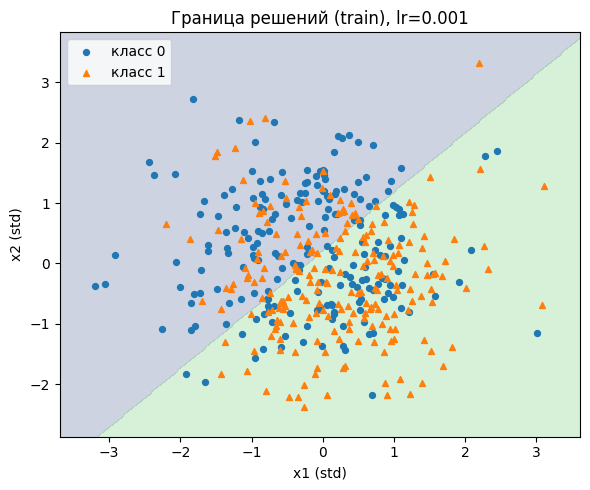

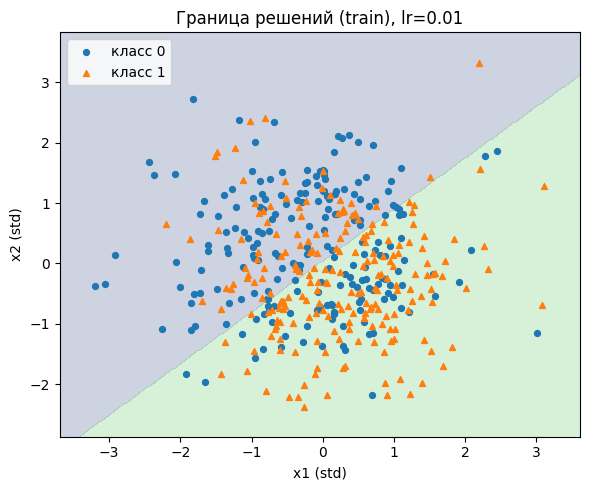

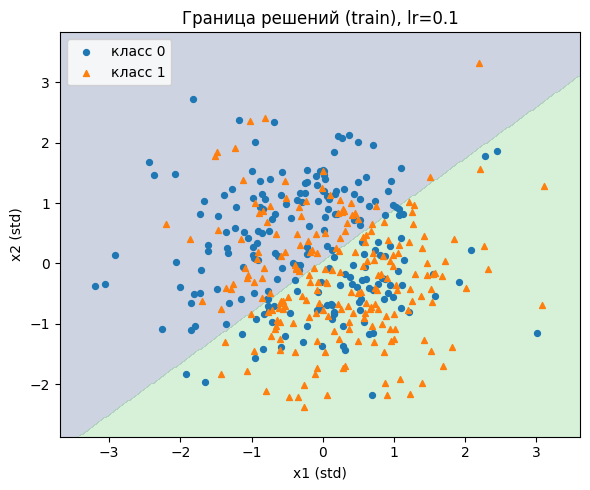

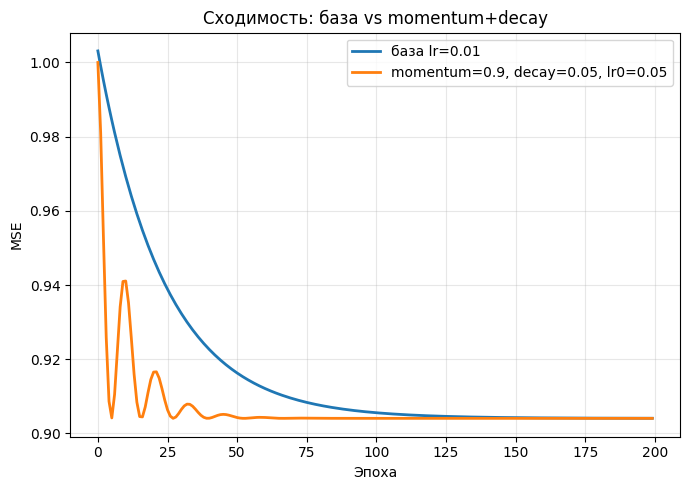

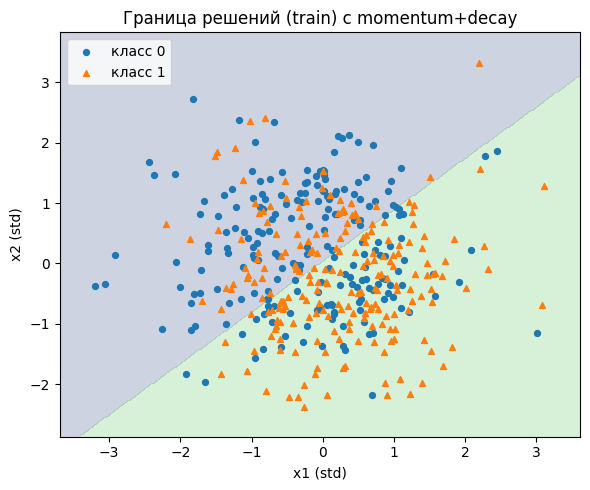

In [1]:
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.datasets import make_moons


def train_test_split_np(X, y, test_size=0.3, random_state=42, shuffle=True):
    rng = np.random.RandomState(random_state)
    n = X.shape[0]
    idx = np.arange(n)
    if shuffle:
        rng.shuffle(idx)
    n_test = int(np.round(n * test_size))
    test_idx = idx[:n_test]
    train_idx = idx[n_test:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

def standardize_train_test(X_train, X_test, eps=1e-8):
    mean = X_train.mean(axis=0, keepdims=True)
    std = X_train.std(axis=0, keepdims=True)
    std = np.where(std < eps, 1.0, std)
    X_train_std = (X_train - mean) / std
    X_test_std = (X_test - mean) / std
    return X_train_std, X_test_std, mean, std

def add_bias(X):
    # Добавляем единичный столбец (bias)
    return np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)


class Adaline:
    def __init__(self, lr=0.01, epochs=200, momentum=0.0, l2=0.0,
                 lr_decay=None, random_state=0, batch_size=None, shuffle=True):
        self.lr = lr
        self.epochs = epochs
        self.momentum = momentum
        self.l2 = l2
        self.lr_decay = lr_decay
        self.random_state = random_state
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.w = None
        self.loss_history_ = []

    def _init_params(self, n_features):
        rng = np.random.RandomState(self.random_state)
        # Маленькая инициализация весов
        self.w = rng.normal(loc=0.0, scale=0.01, size=(n_features,))
        self.v = np.zeros_like(self.w)  # скорость для momentum

    def _iterate_minibatches(self, X, y):
        n = X.shape[0]
        if self.batch_size is None or self.batch_size >= n:
            yield X, y
            return
        idx = np.arange(n)
        if self.shuffle:
            np.random.shuffle(idx)
        for start in range(0, n, self.batch_size):
            end = min(start + self.batch_size, n)
            batch_idx = idx[start:end]
            yield X[batch_idx], y[batch_idx]

    def fit(self, X, y):
        """
        X: [N, d] уже с bias-столбцом
        y: [-1, +1]
        """
        assert X.ndim == 2
        assert y.ndim == 1
        assert set(np.unique(y)).issubset({-1, 1})

        self._init_params(X.shape[1])
        self.loss_history_.clear()

        for epoch in range(self.epochs):
            # для полного батча просто одна итерация
            epoch_loss_accum = 0.0
            n_seen = 0

            lr_t = self.lr
            if self.lr_decay is not None:
                lr_t *= self.lr_decay(epoch)

            for Xb, yb in self._iterate_minibatches(X, y):
                # Прямой проход
                y_pred = Xb @ self.w  # линейный выход
                # Ошибка
                err = yb - y_pred
                # MSE для батча
                batch_mse = np.mean(err**2)
                epoch_loss_accum += batch_mse * Xb.shape[0]
                n_seen += Xb.shape[0]

                # Градиент по w: d/dw (1/N sum (y - Xw)^2) = -(2/N) X^T (y - Xw)
                grad = -(2.0 / Xb.shape[0]) * (Xb.T @ err)

                # L2 (кроме смещения): добавим 2 * l2 * w_no_bias
                if self.l2 > 0.0:
                    l2_grad = np.zeros_like(self.w)
                    l2_grad[1:] = 2.0 * self.l2 * self.w[1:]
                    grad = grad + l2_grad

                # Momentum: v = β v - lr * grad; w += v
                if self.momentum > 0.0:
                    self.v = self.momentum * self.v - lr_t * grad
                    self.w = self.w + self.v
                else:
                    self.w = self.w - lr_t * grad

            epoch_mse = epoch_loss_accum / max(n_seen, 1)
            self.loss_history_.append(epoch_mse)

        return self

    def predict_raw(self, X):
        return X @ self.w

    def predict(self, X):
        # Класс по знаку
        y_lin = self.predict_raw(X)
        return np.where(y_lin >= 0.0, 1, -1)

    def score(self, X, y):
        y_pred = self.predict(X)
        return (y_pred == y).mean()

# ==========================
# Построение графиков
# ==========================
def plot_data_scatter(X, y, title="Данные (train+test)"):
    plt.figure(figsize=(6, 5))
    y01 = (y + 1) // 2
    plt.scatter(X[y01 == 0, 0], X[y01 == 0, 1], s=18, label="класс 0")
    plt.scatter(X[y01 == 1, 0], X[y01 == 1, 1], s=18, label="класс 1", marker='^')
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.tight_layout()

def plot_loss_curves(histories, labels, title="Сходимость (MSE)"):
    plt.figure(figsize=(7, 5))
    for h, lab in zip(histories, labels):
        plt.plot(h, label=lab, linewidth=2)
    plt.xlabel("Эпоха")
    plt.ylabel("MSE")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

def plot_decision_boundary(model, X, y, title="Граница решений (train)"):
    # X без bias (стандартизованные признаки)
    X_wo_bias = X[:, 1:]
    x1_min, x1_max = X_wo_bias[:, 0].min() - 0.5, X_wo_bias[:, 0].max() + 0.5
    x2_min, x2_max = X_wo_bias[:, 1].min() - 0.5, X_wo_bias[:, 1].max() + 0.5
    xx1, xx2 = np.meshgrid(
        np.linspace(x1_min, x1_max, 300),
        np.linspace(x2_min, x2_max, 300),
    )
    grid = np.c_[np.ones(xx1.size), xx1.ravel(), xx2.ravel()]
    zz = model.predict(grid).reshape(xx1.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx1, xx2, zz, alpha=0.25, levels=[-1, 0, 1])
    y01 = (y + 1) // 2
    plt.scatter(X_wo_bias[y01 == 0, 0], X_wo_bias[y01 == 0, 1], s=18, label="класс 0")
    plt.scatter(X_wo_bias[y01 == 1, 0], X_wo_bias[y01 == 1, 1], s=18, marker='^', label="класс 1")
    plt.title(title)
    plt.xlabel("x1 (std)")
    plt.ylabel("x2 (std)")
    plt.legend()
    plt.tight_layout()

def save_current_fig(path):
    plt.savefig(path, dpi=160, bbox_inches='tight')
    print(f"[saved] {path}")

# ==========================
# Основной скрипт
# ==========================
def main():
    # --- 1) Данные ---
    n_samples = 600
    noise = 0.1 * 19
    X, y01 = make_moons(n_samples=n_samples, noise=noise, random_state=7)
    # Переводим метки {0,1} -> {-1, +1}
    y = 2 * y01 - 1

    # Трен/тест
    X_train, X_test, y_train, y_test = train_test_split_np(X, y, test_size=0.3, random_state=42)
    # Стандартизация по train
    X_train_std, X_test_std, mean, std = standardize_train_test(X_train, X_test)

    # Добавляем bias
    X_train_b = add_bias(X_train_std)
    X_test_b = add_bias(X_test_std)

    # Сохраним общий scatter (в стандартизированных координатах для наглядности)
    X_all_b = np.vstack([X_train_b, X_test_b])
    y_all = np.concatenate([y_train, y_test])
    plot_data_scatter(X_all_b[:, 1:], y_all, title="Данные (std) train+test")
    save_current_fig("fig_data_scatter.png")

    # --- 2) Базовый Adaline: сравнение learning rate ---
    lrs = [0.001, 0.01, 0.1]
    models = []
    histories = []
    labels = []

    for lr in lrs:
        model = Adaline(lr=lr, epochs=200, momentum=0.0, l2=0.0,
                        lr_decay=None, random_state=0, batch_size=None)
        model.fit(X_train_b, y_train)
        models.append(model)
        histories.append(model.loss_history_)
        labels.append(f"lr={lr}")

    # График сходимости
    plot_loss_curves(histories, labels, title="Сходимость (MSE) для разных lr")
    save_current_fig("fig_loss_lr.png")

    # Границы решений для каждого lr (на train)
    for lr, model in zip(lrs, models):
        plot_decision_boundary(model, X_train_b, y_train, title=f"Граница решений (train), lr={lr}")
        save_current_fig(f"fig_boundary_train_lr{lr}.png")

    # Метрики
    print("\nИтоговые метрики (база):")
    print("LR        |  Train Acc |  Test Acc |  Final MSE")
    print("-----------------------------------------------")
    for lr, model in zip(lrs, models):
        tr_acc = model.score(X_train_b, y_train)
        te_acc = model.score(X_test_b, y_test)
        final_mse = model.loss_history_[-1]
        print(f"{lr:<9} |  {tr_acc:9.3f} |  {te_acc:8.3f} |  {final_mse:9.4f}")

    # --- 3) Модификация: momentum + decay ---
    # Полиномиальный decay: lr_t = lr0 / sqrt(1 + decay * epoch)
    def poly_decay_fn(decay=0.05):
        return lambda t: 1.0 / np.sqrt(1.0 + decay * t)

    base_lr = 0.05
    mom = 0.9
    decay = 0.05

    model_mod = Adaline(lr=base_lr, epochs=200, momentum=mom, l2=0.0,
                        lr_decay=poly_decay_fn(decay), random_state=1, batch_size=None)
    model_mod.fit(X_train_b, y_train)

    # Сравнение кривых: лучший базовый (пусть lr=0.01) vs модифицированный
    # (Если хочешь, можно выбрать базовый с минимальным финальным MSE автоматически)
    base_ref = models[lrs.index(0.01)]
    plot_loss_curves(
        [base_ref.loss_history_, model_mod.loss_history_],
        [f"база lr=0.01", f"momentum={mom}, decay={decay}, lr0={base_lr}"],
        title="Сходимость: база vs momentum+decay"
    )
    save_current_fig("fig_loss_modification.png")

    # Граница решений модифицированной модели
    plot_decision_boundary(model_mod, X_train_b, y_train,
                           title=f"Граница решений (train) с momentum+decay")
    save_current_fig("fig_boundary_train_momentum.png")

    # Метрики модификации
    tr_acc_m = model_mod.score(X_train_b, y_train)
    te_acc_m = model_mod.score(X_test_b, y_test)
    final_mse_m = model_mod.loss_history_[-1]
    print("\nМодификация (momentum+decay):")
    print("Train Acc | Test Acc | Final MSE")
    print("-------------------------------")
    print(f"{tr_acc_m:9.3f} | {te_acc_m:8.3f} | {final_mse_m:9.4f}")

    #  4) Сохранение всех графиков в единый PDF
    pdf_paths = [
        "fig_data_scatter.png",
        "fig_loss_lr.png",
        f"fig_boundary_train_lr{lrs[0]}.png",
        f"fig_boundary_train_lr{lrs[1]}.png",
        f"fig_boundary_train_lr{lrs[2]}.png",
        "fig_loss_modification.png",
        "fig_boundary_train_momentum.png",
    ]
    pdf_out = "report_delta_rule_moons.pdf"
    with PdfPages(pdf_out) as pdf:
        for p in pdf_paths:
            fig = plt.figure()
            img = plt.imread(p)
            plt.imshow(img)
            plt.axis('off')
            pdf.savefig(fig, bbox_inches='tight')
            plt.close(fig)
    print(f"\n[PDF] Собран общий отчёт с рисунками: {pdf_out}")

    #  5) Короткие текстовые выводы для отчёта
    print("\nКраткие выводы:")
    print("- На линейно неразделимых «лунах» Adaline сходится по MSE к решению наименьших квадратов.")
    print("- Увеличение lr ускоряет начало спуска, но при слишком большом lr возможны колебания.")
    print("- Momentum+decay достигает плато быстрее и стабильнее базового варианта с фиксированным lr.")
    print("- Максимальная точность ограничена линейной границей (геометрией данных).")

if __name__ == "__main__":
    main()